In [1]:
! pip install adabound

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm

import torch
from torchvision import datasets, transforms

from adabound import AdaBound

from ResNetMNIST import ResNetMNIST

from pipeline import Pipeline

<ipython-input-2-51f2be0f49e3>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [3]:
# get mean and std for the train data in order to normalize our data later
trainset      = datasets.MNIST(download=True, train=True, transform=transforms.ToTensor(), root=".")
trainloader   = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)
trainset_mean = next(iter(trainloader))[0].mean(axis=(0, 2, 3))[0]
trainset_std  = next(iter(trainloader))[0].std( axis=(0, 2, 3))[0]
print(f' Trainset mean value for each channel is: {trainset_mean:.2f}')
print(f' Trainset std  value for each channel is: {trainset_std :.2f}')

def normalized_tensor_to_image(tt, mean, std):
    return np.transpose(tt.detach().clone(), (1, 2, 0))*(std[(None, )*2]) + (mean[(None, )*2])

 Trainset mean value for each channel is: 0.13
 Trainset std  value for each channel is: 0.31


In [4]:
transform   = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.ToTensor(),
                                  transforms.Lambda(lambda x: x.repeat(3, 1, 1)), #grayscale to RGB
                                  transforms.Normalize(trainset_mean, trainset_std)])

trainset    = datasets.MNIST('./data', download=True, train=True,  transform=transform)
testset     = datasets.MNIST('./data', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=64, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


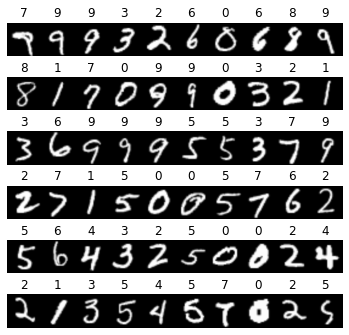

In [6]:
def min_max_scaling(img):
    return (img-img.min())/(img.max()-img.min())

fig = plt.figure(figsize=(6, 6))
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(min_max_scaling(np.transpose(images[index], (1, 2, 0))[:, :, 0]), cmap='gray')
    plt.title(int(labels[index].cpu()))
    plt.subplots_adjust(hspace=0, wspace=0)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNetMNIST(pretrained=True,
                    feature_extraction=True)

criterion = torch.nn.CrossEntropyLoss() # loss function -- cross entropy works well for multi-class problems
optimizer = AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)

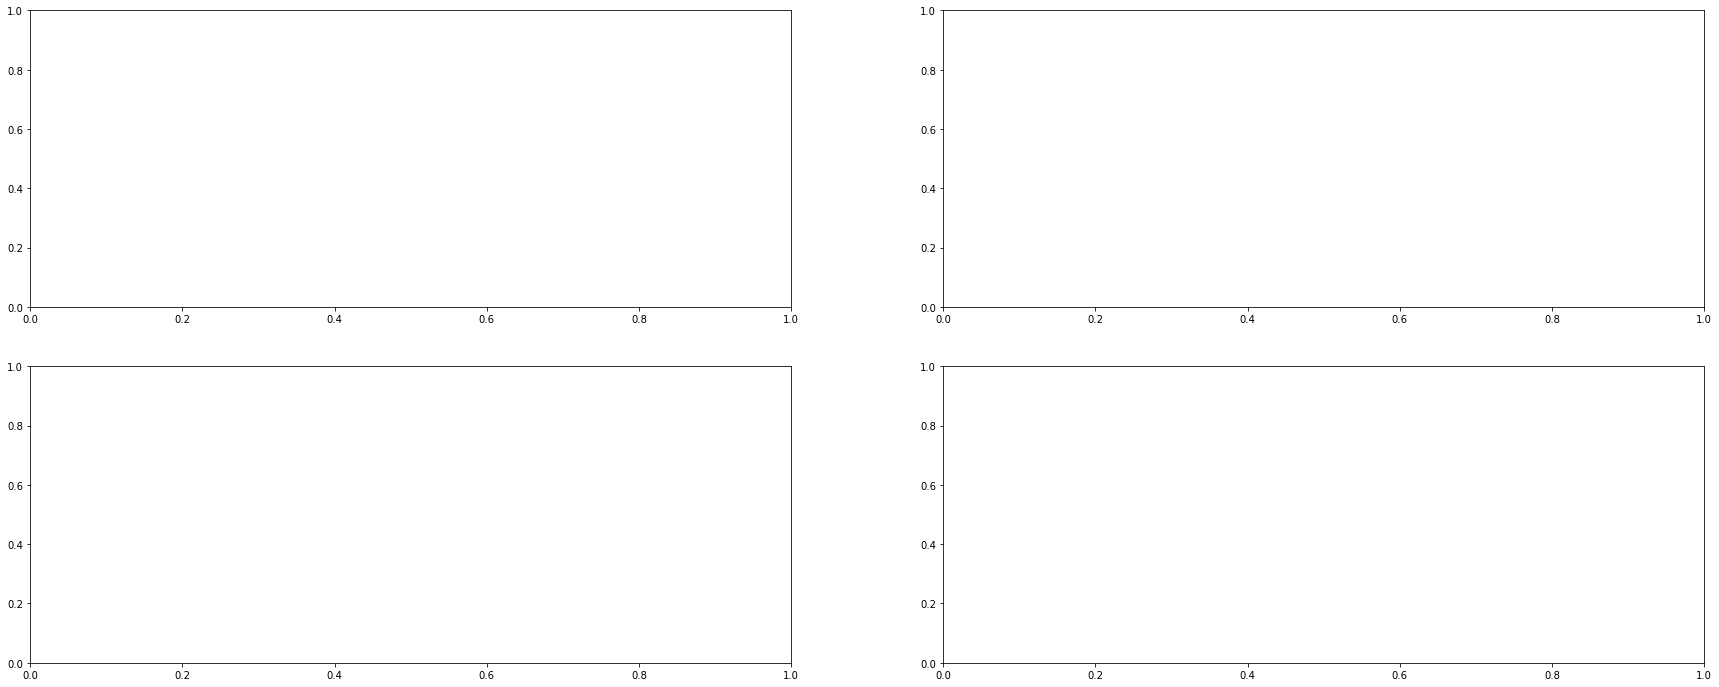

In [8]:
ppln = Pipeline(model, device, optimizer, criterion, trainloader, testloader, testloader, live_plot=True)

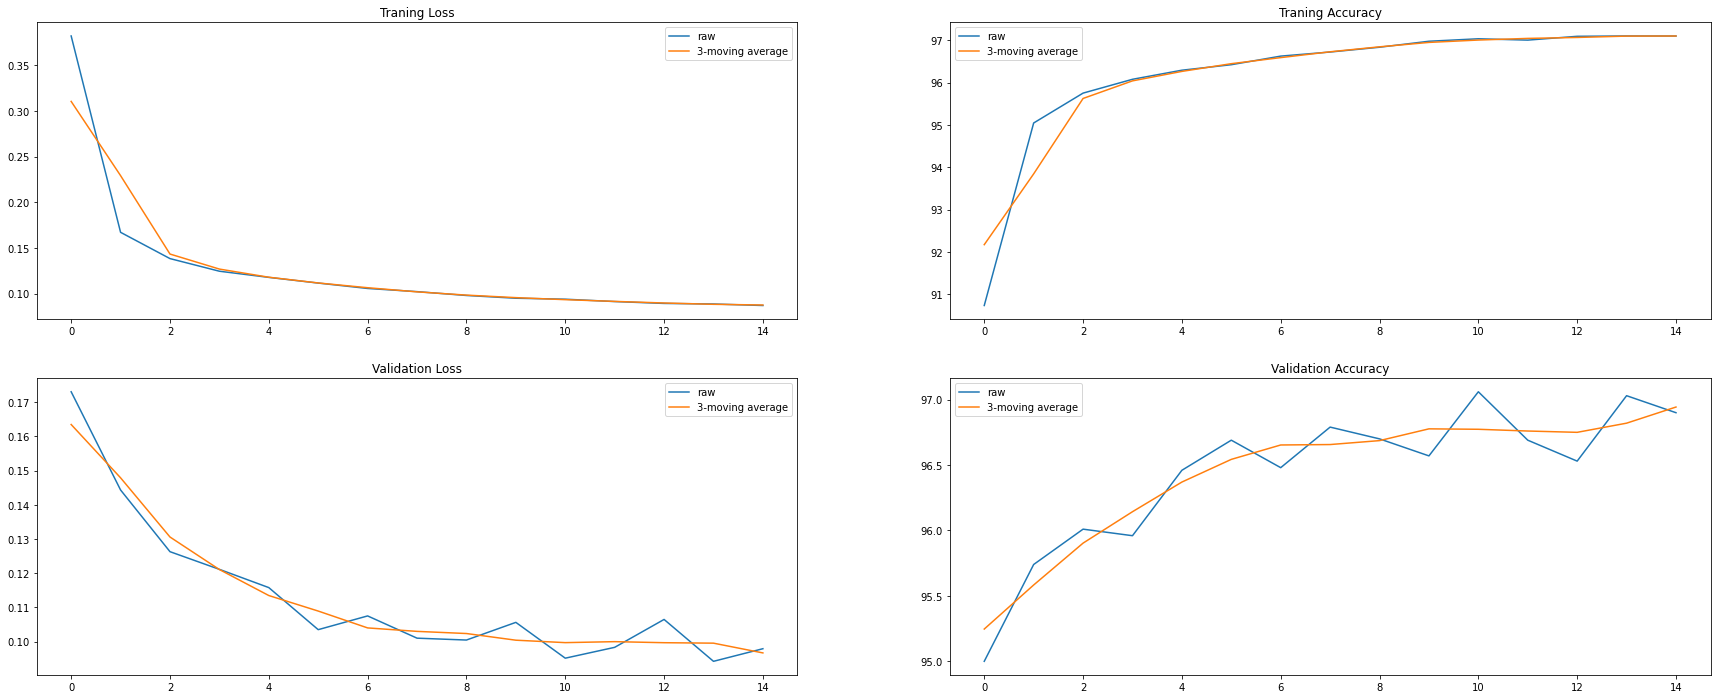

Training complete in 23m 54s
14 epochs done. Best validation accuracy is 97.060. Best validation loss is 0.094


In [13]:
_ = ppln.training(epochs=5)

In [14]:
_ = ppln.test(model=ppln.best_model)

In [15]:
torch.save(ppln.best_model.state_dict(), os.path.join(os.getcwd(), 'MNISTresNetModel_adabound.pth'))